In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR

In [11]:
transform = transforms.Compose([transforms.Resize((256, 170)), transforms.ToTensor()])

In [12]:
# train_ds = ImageFolder('/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/train', transform = transform)
# test_ds = ImageFolder('/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test', transform=transform)

In [13]:
ds = ImageFolder('/kaggle/input/adni-extracted-axial/Axial', transform = transform)

In [14]:
train_ds, test_ds = train_test_split(ds, test_size=0.05, random_state = 32)

In [15]:
len(train_ds), len(test_ds)

(4896, 258)

In [16]:
device = torch.device('cuda')

In [17]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 3)
model = model.to(device) 

LR = 1e-4
BATCH_SIZE = 32

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay = 0.1)
scheduler = CosineAnnealingLR(optimizer,T_max=100, eta_min = 1e-6) # Minimum learning rate.

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)

train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True)

In [18]:
EPOCHS = 10

max_acc = 0
history_loss = []
history_acc = []

for e in range(EPOCHS):
    print('EPOCH', e+1, '\n')
    LOSS = 0
    model.train()
    for images, labels in tqdm(train_dataloader, desc='Training'):
        
        images = images.to(device)
        labels = labels.to(device) 
        
        optimizer.zero_grad()
        outputs = model(images) 
        if True:
            loss = criterion(outputs, labels) 
        else:
            loss = criterion_DRW(outputs, labels)
        LOSS += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step() 
        
        
    LOSS = LOSS/len(train_dataloader)
    history_loss.append(LOSS)
    model.eval()
    
    targets = []
    predictions = [] 
    
    for images,labels in tqdm(test_dataloader, desc='Validation'):
        
        images = images.to(device)
        
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu()
        
        targets.extend(labels) 
        predictions.extend(outputs) 
    
    
    acc = accuracy_score(targets, predictions)
    history_acc.append(acc)
    if acc > max_acc:
        max_acc = acc 
        torch.save(model.state_dict(), 'resnet50_best_ckpt.pth')
    torch.save(model.state_dict(), 'resnet50_ckpt.pth')
    print('Loss: ', LOSS, ' Accuracy: ', round(acc*100,2), 'Best: ', round(max_acc*100,2)) 


EPOCH 1 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.3139408531726575  Accuracy:  98.84 Best:  98.84
EPOCH 2 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.14788946172137277  Accuracy:  100.0 Best:  100.0
EPOCH 3 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.13599161423888861  Accuracy:  98.45 Best:  100.0
EPOCH 4 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.06875556200176623  Accuracy:  74.03 Best:  100.0
EPOCH 5 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.08854215194203349  Accuracy:  87.21 Best:  100.0
EPOCH 6 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.12658945852707998  Accuracy:  99.61 Best:  100.0
EPOCH 7 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.10519134749664492  Accuracy:  99.22 Best:  100.0
EPOCH 8 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.05642828766676579  Accuracy:  81.78 Best:  100.0
EPOCH 9 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.05951121187117559  Accuracy:  96.51 Best:  100.0
EPOCH 10 



Training:   0%|          | 0/153 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Loss:  0.11477893631101824  Accuracy:  100.0 Best:  100.0


In [19]:
from matplotlib import pyplot as plt 

Text(0, 0.5, 'Loss')

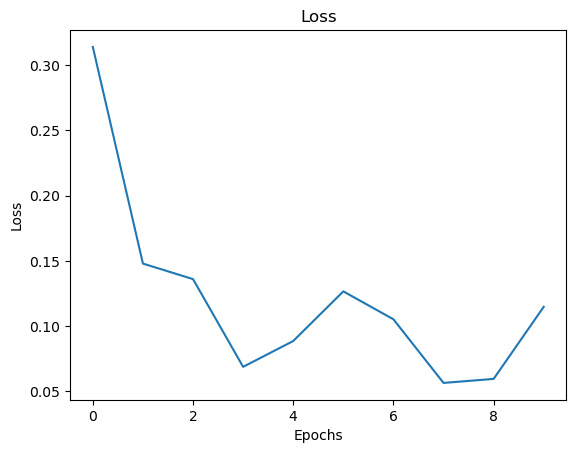

In [20]:
plt.plot(list(range(EPOCHS)), history_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Acc (%)')

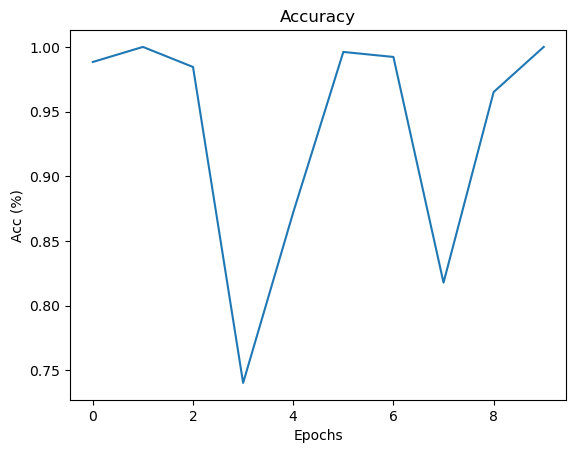

In [21]:
plt.plot(list(range(EPOCHS)), history_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc (%)')

In [22]:
num_classes = [0,0,0]

for im, label in test_ds:
    num_classes[label] += 1

In [23]:
labels = ['AD', 'CN', 'MCI']

Text(0, 0.5, 'No. of training samples')

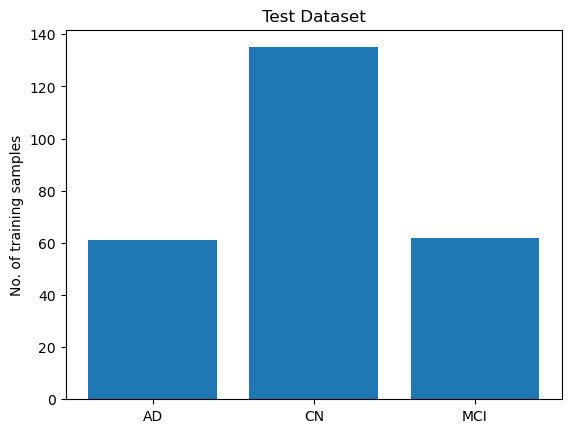

In [24]:
plt.bar(labels, num_classes)
plt.title('Test Dataset')
plt.ylabel('No. of training samples')

In [25]:
checkpoint = torch.load('/kaggle/working/resnet50_best_ckpt.pth')
model.load_state_dict(checkpoint)
model = model.eval()

In [26]:
targets = [] 
predictions = [] 


for im, label in tqdm(test_dataloader):
    
    im = im.to(torch.device('cuda'))
    
    outputs = model(im)
    outputs = torch.argmax(outputs, dim=1).cpu()
    
    predictions.extend(outputs)
    targets.extend(label)
    
print(accuracy_score(targets, predictions))

  0%|          | 0/9 [00:00<?, ?it/s]

1.0
